# __S2FFT CUDA Implementation__
---

[![colab image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/astro-informatics/s2fft/blob/main/notebooks/JAX_HEALPix_frontend.ipynb)

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

# Install s2fft and data if running on google colab.
if IN_COLAB:
    !pip install s2fft &> /dev/null

Short comparaison between the pure JAX implementation and the CUDA implementation of the S2FFT algorithm.

In [4]:
import jax
from jax import numpy as jnp
import argparse
import time

jax.config.update("jax_enable_x64", False)

from s2fft.utils.healpix_ffts import healpix_ifft_nospec_jax, spectral_folding_jax, spectral_periodic_extension_jax, \
    healpix_fft_jax, healpix_ifft_jax, healpix_fft_cuda, healpix_ifft_cuda

In [5]:
def run_fwd_test(nside):
    L = 2 * nside 

    total_pixels = 12 * nside**2
    arr = jax.random.normal(jax.random.PRNGKey(0), (total_pixels, ))

    start = time.perf_counter()
    cuda_res = healpix_fft_cuda(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    cuda_jit_time = end - start

    start = time.perf_counter()
    cuda_res = healpix_fft_cuda(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    cuda_run_time = end - start

    start = time.perf_counter()
    jax_res = healpix_fft_jax(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    jax_jit_time = end - start

    start = time.perf_counter()
    jax_res = healpix_fft_jax(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    jax_run_time = end - start

    print(f"FWD nside: {nside}, cuda_jit_time: {cuda_jit_time}, cuda_run_time: {cuda_run_time}, jax_jit_time: {jax_jit_time}, jax_run_time: {jax_run_time}")

    return cuda_jit_time , cuda_run_time, jax_jit_time, jax_run_time


def run_bwd_test(nside):

    L = 2 * nside
    ftm_shape = (4 * nside - 1, 2 * L)
    ftm_size = ftm_shape[0] * ftm_shape[1]

    arr = jax.random.normal(jax.random.PRNGKey(0), ftm_shape)

    start = time.perf_counter()
    cuda_res = healpix_ifft_cuda(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    cuda_jit_time = end - start

    start = time.perf_counter()
    cuda_res = healpix_ifft_cuda(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    cuda_run_time = end - start

    start = time.perf_counter()
    jax_res = healpix_ifft_jax(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()

    jax_jit_time = end - start
    
    start = time.perf_counter()
    jax_res = healpix_ifft_jax(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    jax_run_time = end - start

    print(f"BWD nside: {nside}, cuda_jit_time: {cuda_jit_time}, cuda_run_time: {cuda_run_time}, jax_jit_time: {jax_jit_time}, jax_run_time: {jax_run_time}")

    return cuda_jit_time , cuda_run_time, jax_jit_time, jax_run_time

In [ ]:
jax.clear_caches()

In [6]:
fwd_times = []
bwd_times = []
nsides = [4 , 8, 16, 32, 64 , 128, 256, 512]
for nside in nsides:
    fwd_times.append(run_fwd_test(nside))
    bwd_times.append(run_bwd_test(nside))

2024-05-22 21:54:24.910564: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


FWD nside: 4, cuda_jit_time: 0.06711979598912876, cuda_run_time: 0.00016343699826393276, jax_jit_time: 0.22756467398721725, jax_run_time: 0.00016358200809918344
BWD nside: 4, cuda_jit_time: 0.0353435669967439, cuda_run_time: 0.00016170999151654541, jax_jit_time: 0.25220271199941635, jax_run_time: 0.00020208500791341066
FWD nside: 8, cuda_jit_time: 0.04405807799776085, cuda_run_time: 0.00017963099526241422, jax_jit_time: 0.3666873409965774, jax_run_time: 0.00021466398902703077
BWD nside: 8, cuda_jit_time: 0.03964304699911736, cuda_run_time: 0.00020775299344677478, jax_jit_time: 0.492015669005923, jax_run_time: 0.0002708179963519797
FWD nside: 16, cuda_jit_time: 0.06744198499654885, cuda_run_time: 0.00025694000942166895, jax_jit_time: 0.8134546340006636, jax_run_time: 0.00030235800659283996
BWD nside: 16, cuda_jit_time: 0.04757145199982915, cuda_run_time: 0.0002956929965876043, jax_jit_time: 0.9915120619989466, jax_run_time: 0.00044038098712917417
FWD nside: 32, cuda_jit_time: 0.07504960

In [37]:
import matplotlib.pyplot as plt
import numpy as np
def plot_times(title, nsides, chrono_times):

    # Extracting times from the chrono_times
    cuda_jit_times = [times[0] for times in chrono_times]
    cuda_run_times = [times[1] for times in chrono_times]
    jax_jit_times = [times[2] for times in chrono_times]
    jax_run_times = [times[3] for times in chrono_times]

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    f2 = lambda a: np.log2(a)
    g2 = lambda b: b**2


    # Plot for JIT times
    ax1.plot(nsides, cuda_jit_times, 'g-o', label='CUDA JIT Time')
    ax1.plot(nsides, jax_jit_times, 'b-o', label='JAX JIT Time')
    ax1.set_title('JIT Compilation Times')
    ax1.set_xlabel('nside')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_xscale('function', functions=(f2, g2))
    ax1.set_xticks(nsides)
    ax1.set_xticklabels(nsides)
    ax1.legend()
    ax1.grid(True, which="both", ls="--")

    # Plot for Run times
    ax2.plot(nsides, cuda_run_times, 'g-o', label='CUDA Run Time')
    ax2.plot(nsides, jax_run_times, 'b-o', label='JAX Run Time')
    ax2.set_title('Execution Times')
    ax2.set_xlabel('nside')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_xscale('function', functions=(f2, g2))
    ax2.set_xticks(nsides)
    ax2.set_xticklabels(nsides)
    ax2.legend()
    ax2.grid(True, which="both", ls="--")

    # Set the overall title for the figure
    fig.suptitle(title, fontsize=16)

    # Show the plots
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make space for the suptitle
    plt.show()

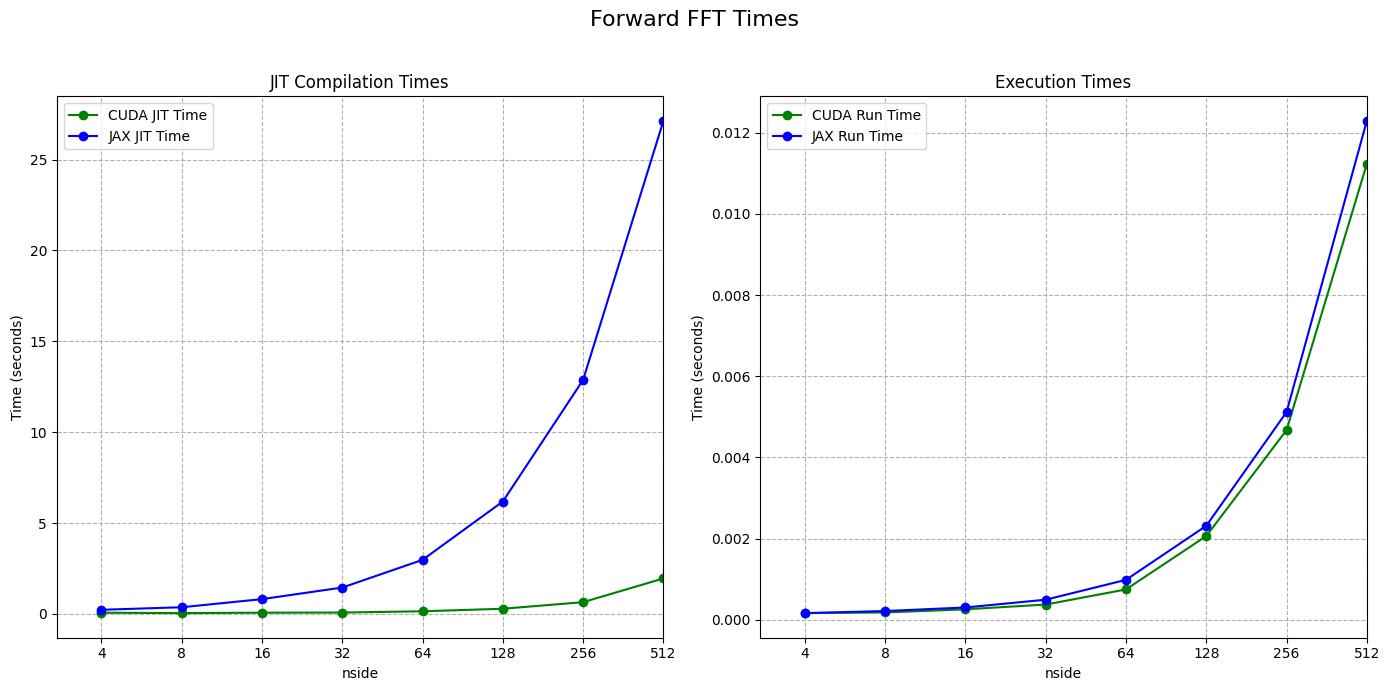

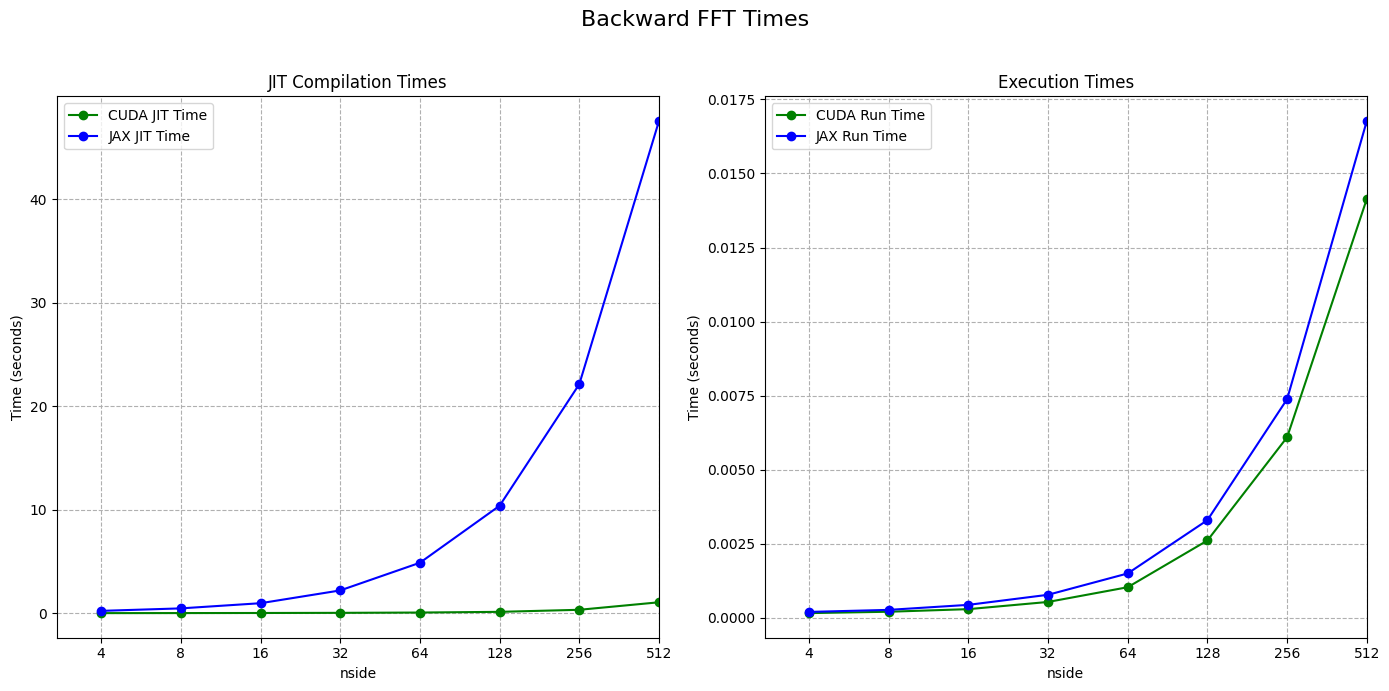

In [38]:

plot_times("Forward FFT Times", nsides, fwd_times)
plot_times("Backward FFT Times", nsides, bwd_times)